In [43]:
from PIL import Image
import sys
import numpy as np
import easyocr
import os
import re
import editdistance
import cv2
from matplotlib import pyplot as plt
from torchmetrics import WordErrorRate, CharErrorRate, MatchErrorRate

In [44]:
%matplotlib inline

In [45]:
cur_path = os.path.dirname(os.getcwd())
data_path = os.path.join(cur_path, "data/natation/")

dic_names = {}
for file in os.listdir(data_path):
    if file[-4:] == ".txt":
        with open(os.path.join(data_path, file), 'r') as f:
            names = f.readlines()
            for n in names:
                complete_name = n.strip().split()[:-1]
                last_name = complete_name[:-1]
                first_name = complete_name[-1]
                if len(last_name) == 1:
                    last_name = ' '.join(complete_name[:-1])
                    if last_name in dic_names:
                        continue
                    else:
                        dic_names[last_name] = first_name
                else:
                    for ln in last_name:
                        if ln in dic_names: # ISSUE IF NAME WITH DIFFERENT FIRDT NAMES
                            continue
                        else:
                            dic_names[ln] = first_name

In [46]:
reader = easyocr.Reader(['en'])

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


In [47]:
def reformat_predictions(raw_predictions):
    return [pred[1] for pred in raw_predictions]

In [48]:
def get_prediction_last_name(prediction, dic_names, min_edit_distance=2):
    pattern = r'[0-9]'
    cprediction = re.sub(pattern, '', prediction.strip()).strip()
    last_names = []
    for comp in cprediction.split(' '):
        for n in dic_names.keys():
            if editdistance.eval(n, comp) <= min_edit_distance:
                last_names.append(comp)
    return last_names

In [49]:
def get_predictions_of_interest(predictions, dic_names):
    preds = []
    for pred in predictions:
        cpred = get_prediction_last_name(pred, dic_names)
        if len(cpred) == 0:
            continue
        elif len(cpred) == 1:
            preds.extend(cpred)
        else:
            cpred = ' '.join(cpred)
            preds.append(cpred)
    return preds

In [50]:
def get_ground_truth(path):
    ground_truth = []
    pattern = r'[0-9]'
    with open(path, "r") as f:
        ground_truth.extend([re.sub(pattern, '', y.strip()).strip(':., ') for y in f.readlines()])
    return ground_truth

In [51]:
def get_last_names_ground_truth(ground_truth):
    return [' '.join(gt.split(' ')[:-1]) for gt in ground_truth]

In [52]:
def compute_metrics(predictions_of_interest, last_names_ground_truth):
    mers = {yhat: 0 for yhat in predictions_of_interest}
    wers = {yhat: 0 for yhat in predictions_of_interest}
    cers = {yhat: 0 for yhat in predictions_of_interest}

    mer = MatchErrorRate()
    wer = WordErrorRate()
    cer = CharErrorRate()

    for yhat in predictions_of_interest:
        min_mer_error_rate = 1000
        min_wer_error_rate = 1000
        min_cer_error_rate = 1000
        for y in last_names_ground_truth:
            if mer(yhat, y) < min_mer_error_rate:
                min_mer_error_rate = mer(yhat, y)
            if wer(yhat, y) < min_wer_error_rate:
                min_wer_error_rate = wer(yhat, y)
            if cer(yhat, y) < min_cer_error_rate:
                min_cer_error_rate = cer(yhat, y)
        mers[yhat] = min_mer_error_rate.item()
        wers[yhat] = min_wer_error_rate.item()
        cers[yhat] = min_cer_error_rate.item()

    return mers, wers, cers

In [53]:
def compute_metrics_for_image(gt_path, im_path, dic_names):
    ground_truth = get_ground_truth(gt_path)
    last_names_ground_truth = get_last_names_ground_truth(ground_truth)

    predictions = reformat_predictions(reader.readtext(im_path))
    predictions = get_predictions_of_interest(predictions, dic_names)

    return compute_metrics(predictions, last_names_ground_truth)

In [54]:
def get_final_metric(gt_path, im_path, dic_names):
    ground_truth = get_ground_truth(gt_path)
    ground_truth = get_last_names_ground_truth(ground_truth)

    mers, wers, cers = compute_metrics_for_image(gt_path, im_path, dic_names)
    global_mer = sum(mers.values())/len(ground_truth)
    global_wer = sum(wers.values())/len(ground_truth)
    global_cer = sum(cers.values())/len(ground_truth)
    
    return global_mer, global_wer, global_cer, (global_mer + global_wer + global_cer) / 3

In [55]:
path_tuples = [(f"00000{i}.png", f"00000{i}.txt") for i in range(10)]
path_tuples.extend([(f"0000{i}.png", f"0000{i}.txt") for i in range(10, 15)])

In [56]:
def evaluate(data_path, path_tuples, dic_names, roi_path='', clip_text_prompt='', clip_visual_prompt=''):
    metrics = []
    mers = []
    wers = []
    cers = []
    for i in range(len(path_tuples)):
        im_path = data_path + roi_path + clip_text_prompt + clip_visual_prompt + path_tuples[i][0]
        gt_path = data_path + path_tuples[i][1]
        m, w, c, gm = get_final_metric(gt_path, im_path, dic_names)
        metrics.append(gm)
        mers.append(m)
        wers.append(w)
        cers.append(c)
    return sum(mers)/len(mers), sum(wers)/len(wers), sum(cers)/len(cers), sum(metrics)/len(metrics)

In [57]:
evaluate(data_path, path_tuples, dic_names)

(0.8051177252474285, 1.452817459406834, 0.7603768309469892, 1.006104005200417)

Evaluation de l'algorithme sur les ROI seulement

In [58]:
evaluate(data_path, path_tuples, dic_names, roi_path='ROI/SegFormer/')

(0.6433624342951194,
 1.2564550252132631,
 0.6485117566518525,
 0.8494430720534117)

In [59]:
evaluate(data_path, path_tuples, dic_names, roi_path='ROI/', clip_text_prompt='CLIP_text_prompt/')

(0.8176216935874924,
 1.4610846555051666,
 0.7781000325324201,
 1.0189354605416931)

In [60]:
evaluate(data_path, path_tuples, dic_names, roi_path='ROI/', clip_visual_prompt='CLIP_visual_prompt/')

(0.6840701062527914, 1.299060845981357, 0.6853035921449699, 0.8894781814597061)

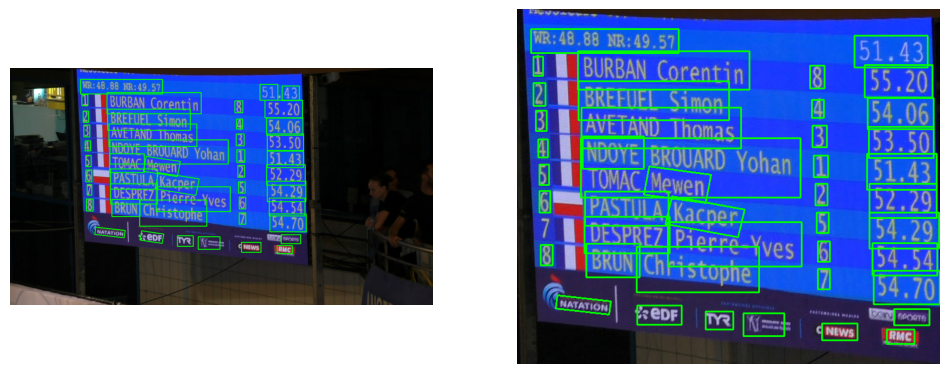

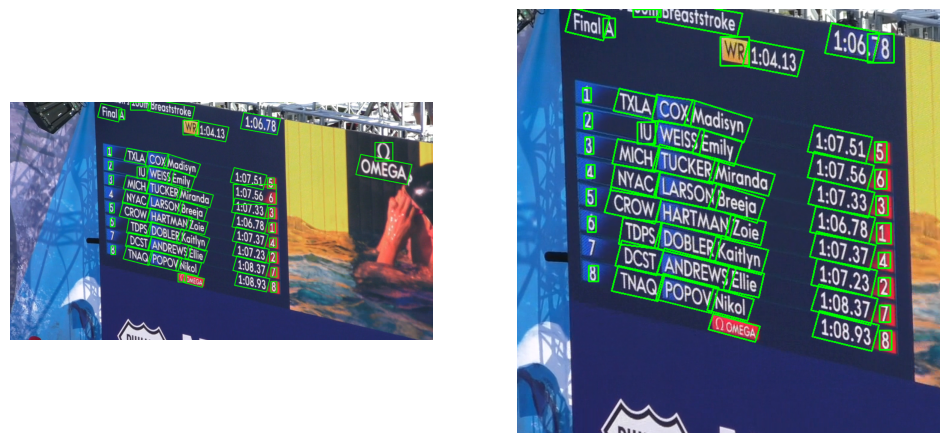

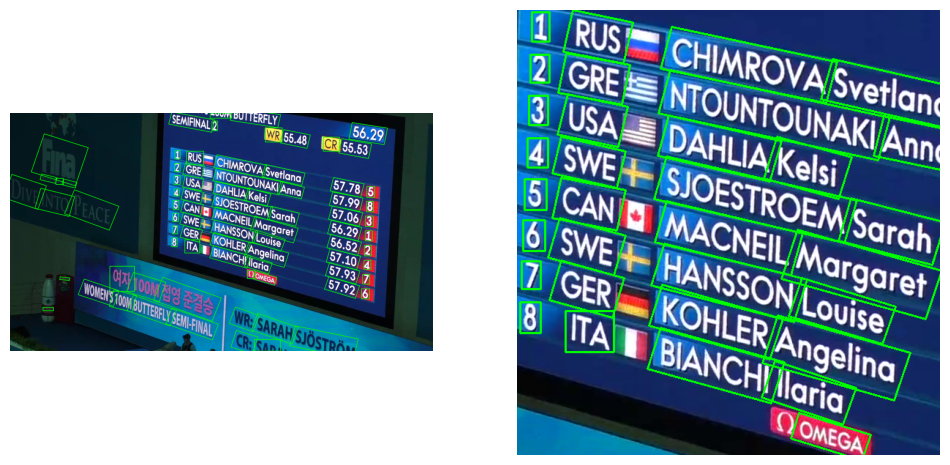

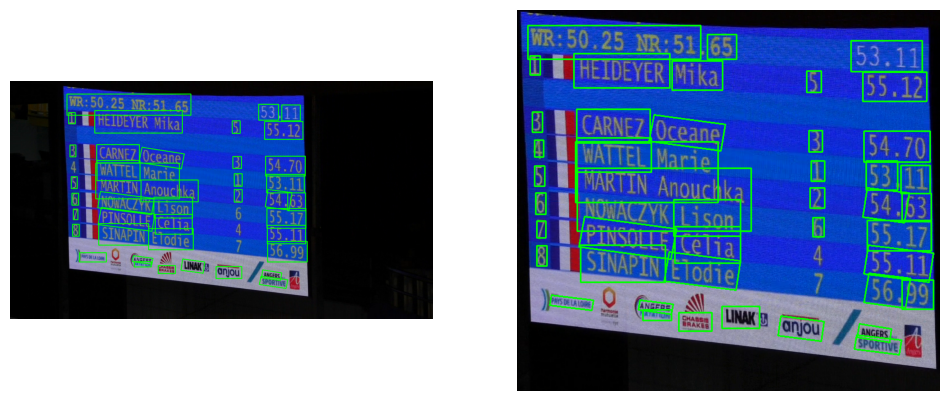

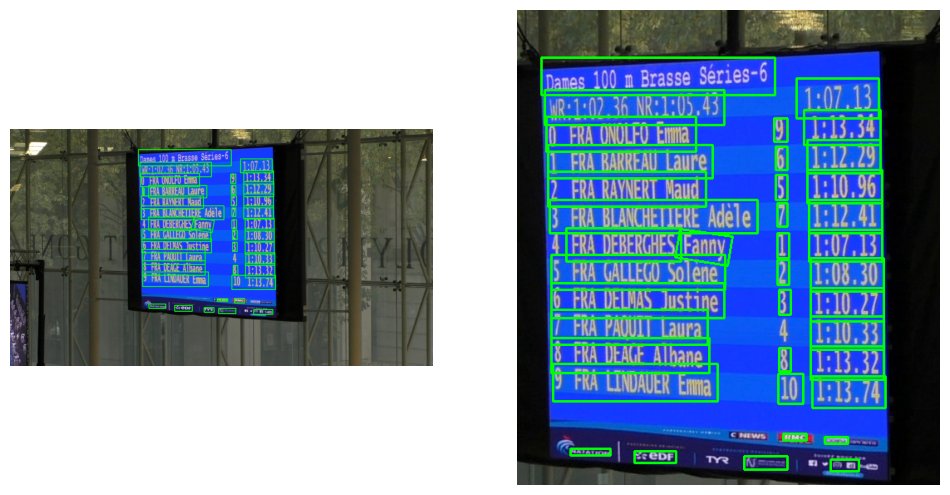

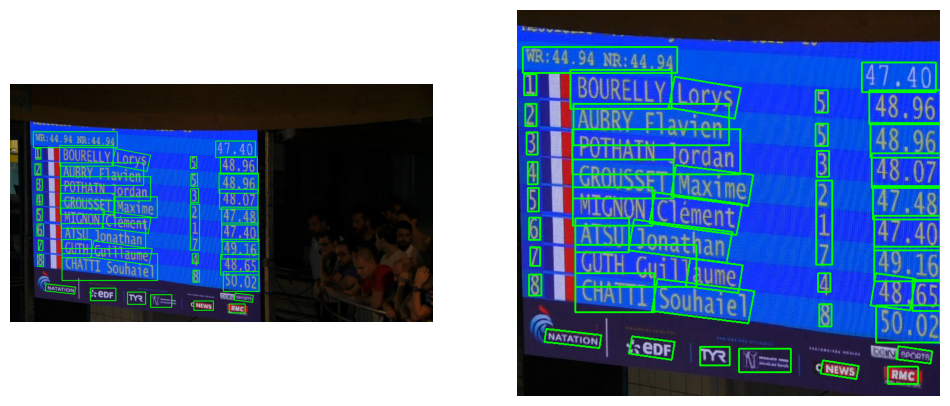

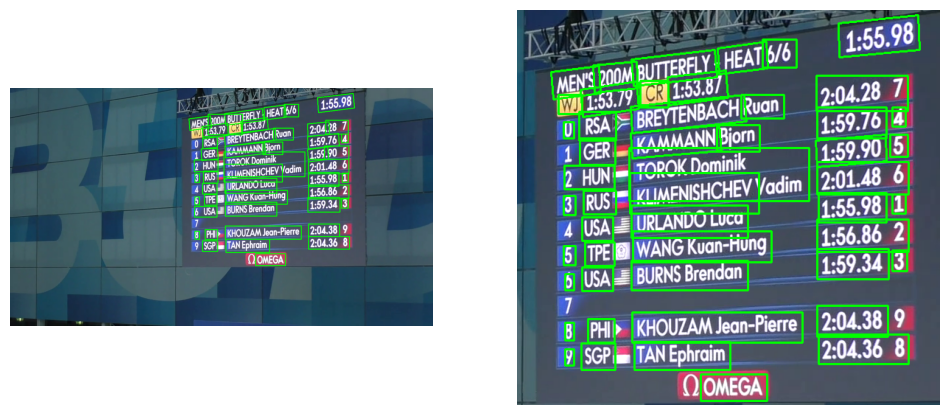

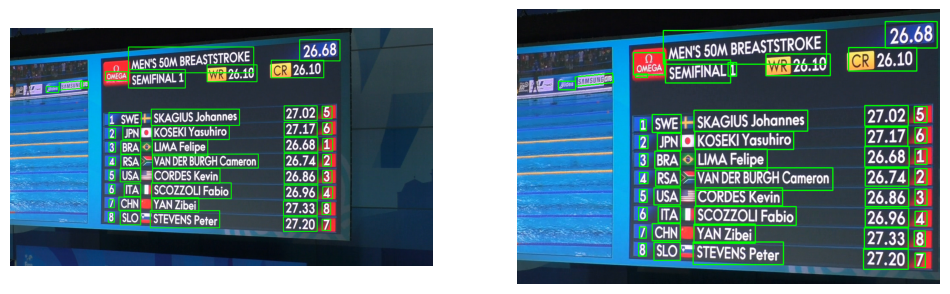

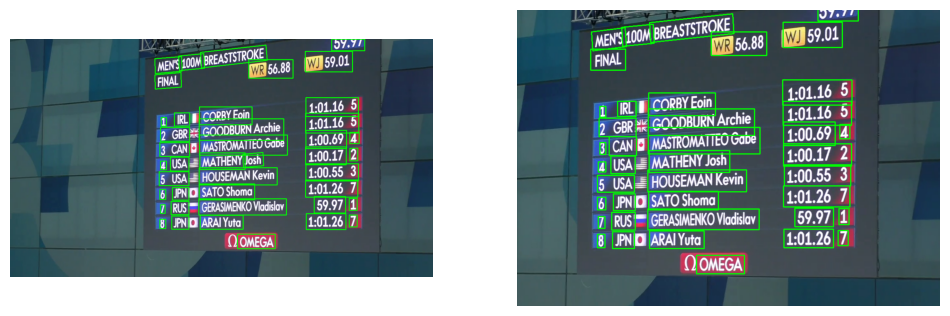

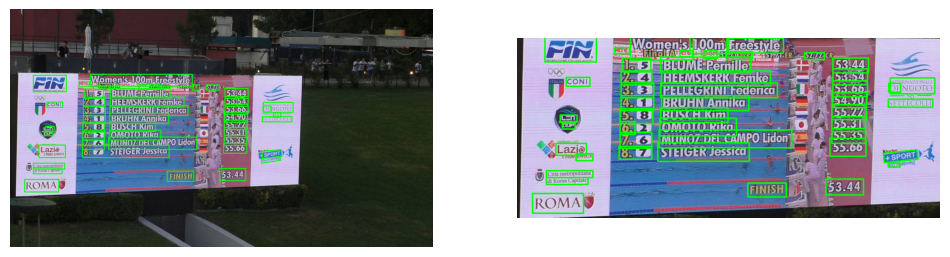

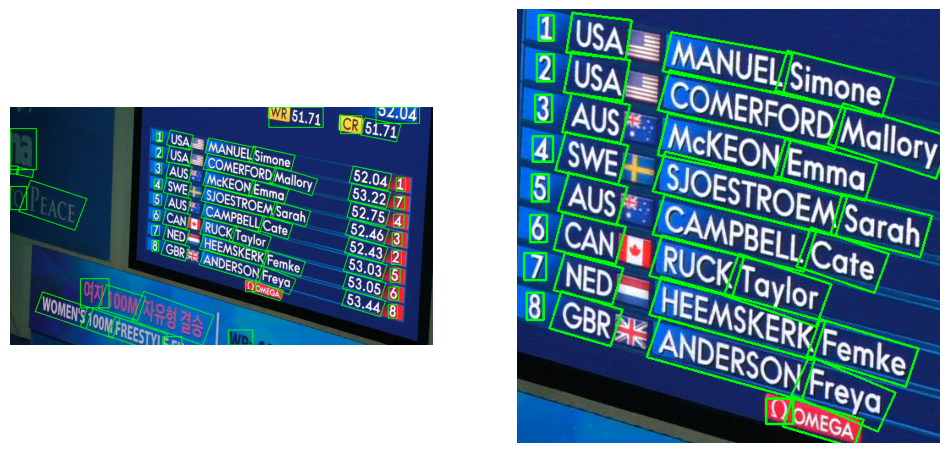

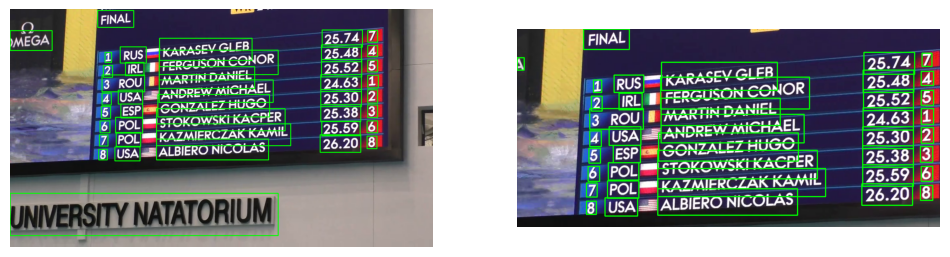

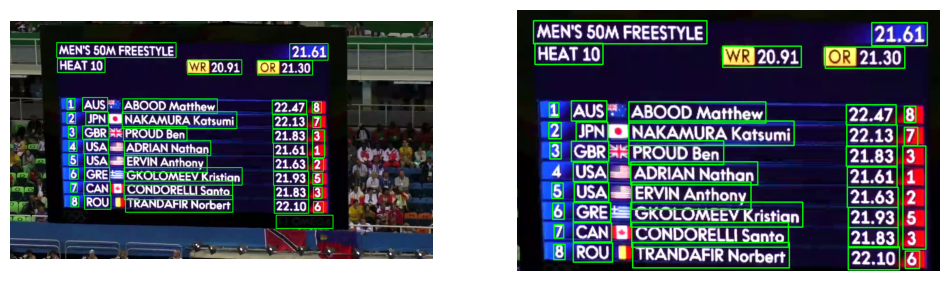

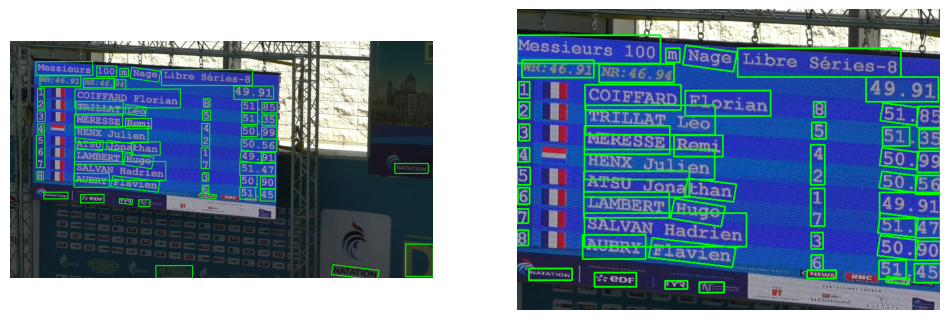

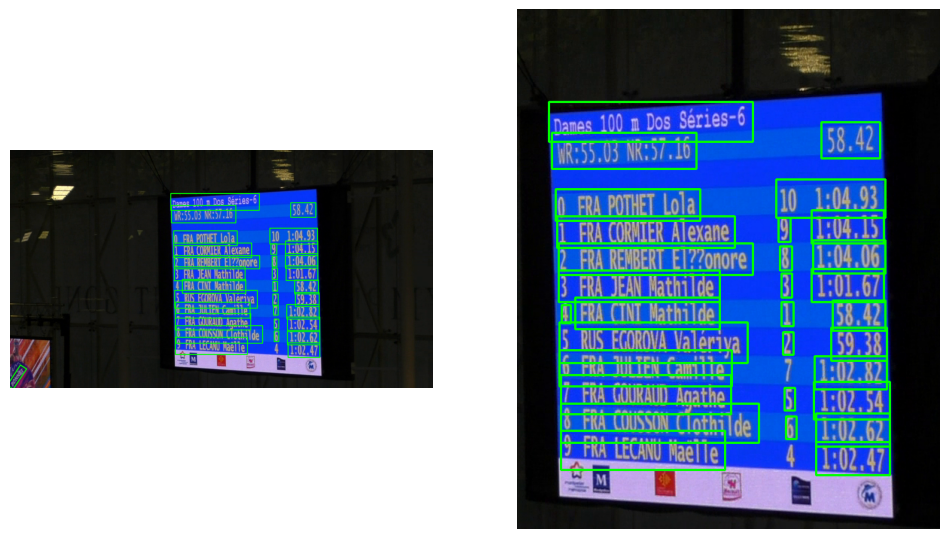

In [42]:
for i in range(len(path_tuples)):
    fig, ax = plt.subplots(1, 2, figsize=(12, 8))
    org_im_path = data_path + path_tuples[i][0]
    seg_im_path = data_path + 'ROI/' + 'SegFormer/' + path_tuples[i][0]
    org_im = cv2.imread(org_im_path)
    seg_im = cv2.imread(seg_im_path)
    org_im = cv2.cvtColor(org_im, cv2.COLOR_BGR2RGB)
    seg_im = cv2.cvtColor(seg_im, cv2.COLOR_BGR2RGB)

    org_bboxes = reader.readtext(org_im)
    org_bboxes = [np.array(elem[0], dtype='int32').reshape(4, 1, 2) for elem in org_bboxes]
    for i in range(len(org_bboxes)):
        cv2.polylines(org_im, [org_bboxes[i]], True, (0, 255, 0), 2)

    seg_bboxes = reader.readtext(seg_im)
    seg_bboxes = [np.array(elem[0], dtype='int32').reshape(4, 1, 2) for elem in seg_bboxes]
    for i in range(len(seg_bboxes)):
        cv2.polylines(seg_im, [seg_bboxes[i]], True, (0, 255, 0), 2)

    org_h, org_w, org_c = org_im.shape
    seg_h, seg_w, seg_c = seg_im.shape

    ax[0].imshow(org_im)
    ax[1].imshow(seg_im)
    ax[0].axis('off')
    ax[1].axis('off')